In [1]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [2]:
import math
import time
import random
from pathlib import Path
from itertools import cycle
from datetime import timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report,
    roc_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


import timm
from torchinfo import summary
from torchview import draw_graph

In [3]:
# --------------------------
# Optionally list all directories (using pathlib)
# --------------------------
input_path = Path('/kaggle/input')
for directory in input_path.rglob('*'):
    if directory.is_dir():
        print(directory)

/kaggle/input/Test cases
/kaggle/input/The IQ-OTHNCCD lung cancer dataset
/kaggle/input/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
/kaggle/input/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases
/kaggle/input/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases
/kaggle/input/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases


In [4]:
# --------------------------
# Step 1: Compute Mean and Std Without Normalization
# --------------------------
batch_size = 8
input_shape = (256, 256, 3)  # Shape of input images
target_size = (256, 256)     # Size for image transformation
seed = 42

In [5]:
data_dir = "/kaggle/input/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"

# Transformation: resize and convert to tensor (NO normalization)
transform_no_norm = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor()
])

# Load dataset (expects class subdirectories)
dataset_no_norm = datasets.ImageFolder(root=data_dir, transform=transform_no_norm)

# Create DataLoader to iterate over dataset in batches
loader = DataLoader(dataset_no_norm, batch_size=batch_size, shuffle=False, num_workers=2)

# Compute mean and std over the dataset
mean = 0.0
std = 0.0
nb_samples = 0

for data, _ in loader:
    batch_samples = data.size(0)  # Number of samples in current batch
    data = data.view(batch_samples, data.size(1), -1)  # (batch_size, channels, H*W)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Calculated mean:", mean)
print("Calculated std:", std)

Calculated mean: tensor([0.4102, 0.4102, 0.4102])
Calculated std: tensor([0.2933, 0.2933, 0.2933])


In [6]:
# --------------------------
# Step 2: Load Full Dataset with Normalization
# --------------------------
data_transforms = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# --------------------------
# Step 3: Split Dataset into Train, Validation, and Test Sets
# --------------------------
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

# Fixed random seed for reproducibility
generator = torch.Generator().manual_seed(seed)
train_dataset, valid_dataset, test_dataset = random_split(
    full_dataset, [train_size, valid_size, test_size], generator=generator
)

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
# --------------------------
# Step 4: Compute class-wise counts for each split using np.bincount
# --------------------------
# Extract targets for each split as NumPy arrays
train_targets = np.array([full_dataset.targets[i] for i in train_dataset.indices])
valid_targets = np.array([full_dataset.targets[i] for i in valid_dataset.indices])
test_targets  = np.array([full_dataset.targets[i] for i in test_dataset.indices])  # corrected here

# Get class names and number of classes from the full dataset
classes = full_dataset.classes
num_classes = len(classes)

# Compute counts per class efficiently with np.bincount
train_counts = np.bincount(train_targets, minlength=num_classes)
valid_counts = np.bincount(valid_targets, minlength=num_classes)
test_counts  = np.bincount(test_targets, minlength=num_classes)

# --------------------------
# Step 5: Display table of counts using Pandas
# --------------------------
import pandas as pd

df = pd.DataFrame({
    'Class': classes,
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
})
print(df)

             Class  Train  Validation  Test
0     Bengin cases     84          19    17
1  Malignant cases    389          86    86
2     Normal cases    294          59    63


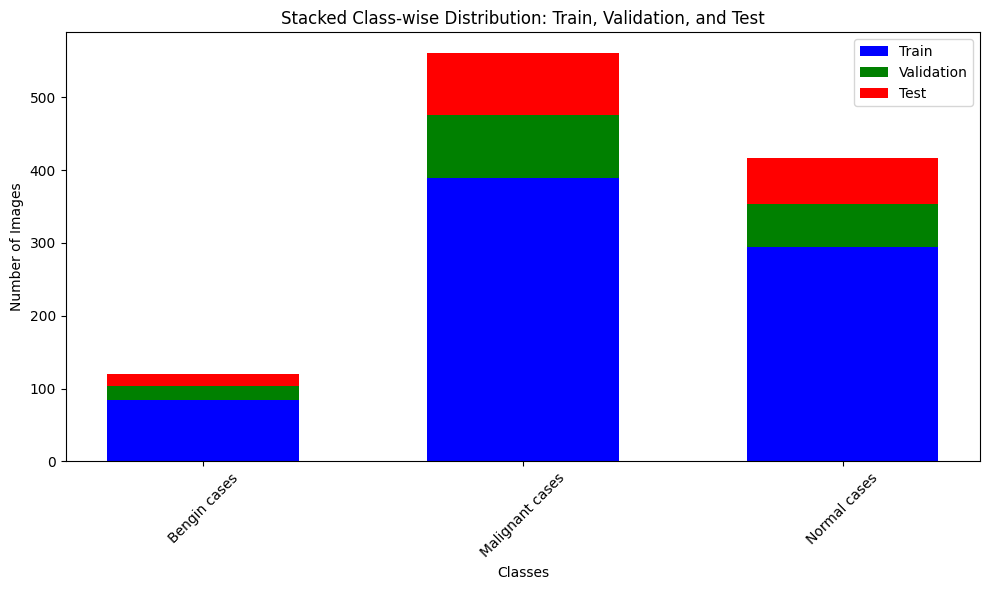

In [8]:
# --------------------------
# Step 6: Plot a single stacked vertical bar plot for each class
# --------------------------
x = np.arange(num_classes)  # positions for each class
bar_width = 0.6

plt.figure(figsize=(10, 6))
# Plot train counts
plt.bar(x, train_counts, bar_width, color='blue', label='Train')
# Stack validation counts on top of train counts
plt.bar(x, valid_counts, bar_width, bottom=train_counts, color='green', label='Validation')
# Stack test counts on top of train + validation counts
plt.bar(x, test_counts, bar_width, bottom=train_counts + valid_counts, color='red', label='Test')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(x, classes, rotation=45)
plt.title('Stacked Class-wise Distribution: Train, Validation, and Test')
plt.legend()
plt.tight_layout()
plt.show()

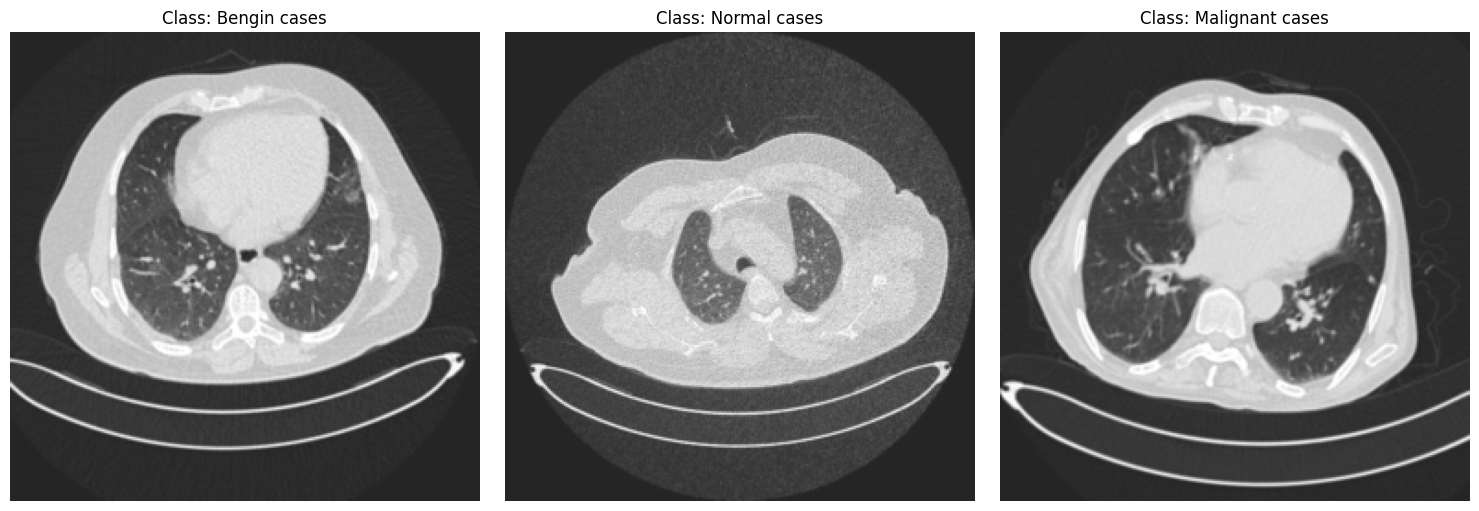

In [9]:
# Set seed for reproducibility
random.seed(seed)
torch.manual_seed(seed)

# Map class index to class name
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Dictionary to store one image per class
random_images_per_class = {}

# Shuffle indices to pick random images
shuffled_indices = list(range(len(full_dataset)))
random.shuffle(shuffled_indices)

# Collect one image per class
for idx in shuffled_indices:
    image_tensor, label = full_dataset[idx]
    if label not in random_images_per_class:
        random_images_per_class[label] = image_tensor
    if len(random_images_per_class) == len(class_to_idx):
        break

# Prepare to plot
num_classes = len(random_images_per_class)
fig, axs = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
if num_classes == 1:
    axs = [axs]  # ensure iterable if only 1 class

# Convert mean and std to numpy arrays for unnormalization
mean_np = np.array(mean)[:, None, None]
std_np = np.array(std)[:, None, None]

# Plot images
for ax, (label, img_tensor) in zip(axs, random_images_per_class.items()):
    # Convert to numpy and undo normalization
    img_np = img_tensor.clone().numpy()
    img_np = img_np * std_np + mean_np
    img_np = np.clip(img_np, 0, 1)

    # Convert to HWC format for matplotlib
    img_np = np.transpose(img_np, (1, 2, 0))

    ax.imshow(img_np)
    ax.set_title(f"Class: {idx_to_class[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
model = timm.create_model('swinv2_tiny_window8_256', pretrained=True, num_classes=num_classes)
summary(model, input_size=(1, 3, 256, 256),
        col_names=["input_size", "output_size", "num_params", "trainable"])

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
SwinTransformerV2                                  [1, 3, 256, 256]          [1, 3]                    --                        True
├─PatchEmbed: 1-1                                  [1, 3, 256, 256]          [1, 64, 64, 96]           --                        True
│    └─Conv2d: 2-1                                 [1, 3, 256, 256]          [1, 96, 64, 64]           4,704                     True
│    └─LayerNorm: 2-2                              [1, 64, 64, 96]           [1, 64, 64, 96]           192                       True
├─Sequential: 1-2                                  [1, 64, 64, 96]           [1, 8, 8, 768]            --                        True
│    └─SwinTransformerV2Stage: 2-3                 [1, 64, 64, 96]           [1, 64, 64, 96]           --                        True
│    │    └─Identity: 3-1                          [1, 64

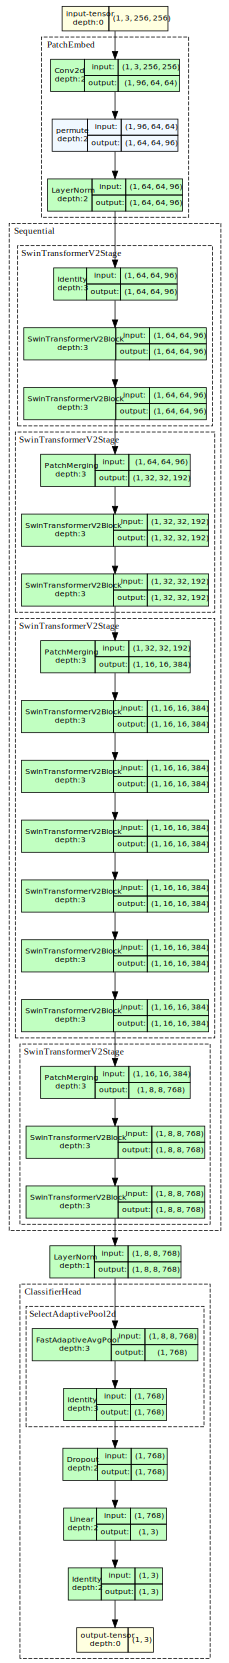

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [12]:
def custom_metrics(y_pred, y_true, loss):
    # Compute predicted classes from probabilities
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Convert tensors to numpy arrays for scikit-learn functions
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()

    # Compute basic metrics
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    # Assuming binary classification for specificity and sensitivity calculations.
    if cm.shape[0] == 2 and cm.shape[1] == 2:
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        specificity = None
        sensitivity = None

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Compute ROC AUC scores per class, only if there are at least 2 unique classes
    num_classes = y_pred.shape[1]
    auc_scores = []
    unique_classes = np.unique(y_true_numpy)
    if len(unique_classes) > 1:
        for class_idx in range(num_classes):
            class_y_true = (y_true_numpy == class_idx).astype(np.float32)
            class_y_pred = y_pred[:, class_idx].cpu().numpy()
            # Skip AUC computation if class_y_true has only one unique value
            if np.all(class_y_true == 0) or np.all(class_y_true == 1):
                continue
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        auc_avg = np.nanmean(auc_scores) if auc_scores else None
    else:
        auc_avg = None

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [13]:
LR = 0.0005
BATCH_SIZE = 8

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss() 

In [14]:
# --------------------------
# Initialize
# --------------------------
num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0
best_val_loss = float('inf')
best_model_state = None  # Optional: keep track of best model

# Metric names and history
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {name: [] for name in metric_names}
val_metrics_history = {name: [] for name in metric_names}

# --------------------------
# Training Loop
# --------------------------
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # --- Training ---
    model.train()
    start_time = time.time()
    total_loss = 0.0
    all_predictions, all_targets = [], []

    for data, targets in tqdm(train_loader, desc="Training"):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    epoch_training_time = time.time() - start_time
    total_training_time += epoch_training_time

    avg_train_loss = total_loss / len(train_loader)
    train_metrics = custom_metrics(
        torch.tensor(all_predictions),
        torch.tensor(all_targets),
        avg_train_loss
    )

    # Log training metrics
    train_line = "Train Metrics - " + ", ".join([
        f"{k}: {v:.4f}" if v is not None else f"{k}: N/A"
        for k, v in train_metrics.items()
    ])
    print(train_line)
    for name in metric_names:
        train_metrics_history[name].append(train_metrics[name])

    # --- Validation ---
    model.eval()
    start_time = time.time()
    total_loss = 0.0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for data, targets in tqdm(valid_loader, desc="Validating"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_validation_time = time.time() - start_time
    total_validation_time += epoch_validation_time

    avg_val_loss = total_loss / len(valid_loader)
    val_metrics = custom_metrics(
        torch.tensor(all_predictions),
        torch.tensor(all_targets),
        avg_val_loss
    )

    # Log validation metrics
    val_line = "Val Metrics   - " + ", ".join([
        f"{k}: {v:.4f}" if v is not None else f"{k}: N/A"
        for k, v in val_metrics.items()
    ])
    print(val_line)
    for name in metric_names:
        val_metrics_history[name].append(val_metrics[name])

    # Optional: Track best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        print(f"New best validation loss: {best_val_loss:.4f}")

# --------------------------
# Timing Summary
# --------------------------
print("\nTraining Completed.")
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_train_time = total_training_time / num_epochs
avg_val_time = total_validation_time / num_epochs
print(f"Avg Training Time per Epoch: {str(timedelta(seconds=avg_train_time))}")
print(f"Avg Validation Time per Epoch: {str(timedelta(seconds=avg_val_time))}")


Epoch 1/25


Training: 100%|██████████| 96/96 [00:11<00:00,  8.47it/s]
/tmp/ipykernel_35/1206543161.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(all_predictions),


Train Metrics - loss: 0.9933, accuracy: 0.4720, precision: 0.4320, recall: 0.4720, f1_score: 0.4134, specificity: N/A, sensitivity: N/A, mcc: -0.0141, auc: 0.5102


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Val Metrics   - loss: 0.9696, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.6436
New best validation loss: 0.9696

Epoch 2/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.97it/s]


Train Metrics - loss: 0.9783, accuracy: 0.4889, precision: 0.3597, recall: 0.4889, f1_score: 0.3538, specificity: N/A, sensitivity: N/A, mcc: -0.0544, auc: 0.4464


Validating: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Val Metrics   - loss: 0.9597, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.6903
New best validation loss: 0.9597

Epoch 3/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.95it/s]


Train Metrics - loss: 0.9760, accuracy: 0.5046, precision: 0.4239, recall: 0.5046, f1_score: 0.4225, specificity: N/A, sensitivity: N/A, mcc: 0.0427, auc: 0.5214


Validating: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Val Metrics   - loss: 0.9746, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.3738

Epoch 4/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.97it/s]


Train Metrics - loss: 0.9597, accuracy: 0.4811, precision: 0.3939, recall: 0.4811, f1_score: 0.4011, specificity: N/A, sensitivity: N/A, mcc: -0.0148, auc: 0.5197


Validating: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Val Metrics   - loss: 0.9623, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5436

Epoch 5/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.99it/s]


Train Metrics - loss: 0.9646, accuracy: 0.5059, precision: 0.4010, recall: 0.5059, f1_score: 0.3478, specificity: N/A, sensitivity: N/A, mcc: -0.0001, auc: 0.4985


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Val Metrics   - loss: 0.9635, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5361

Epoch 6/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.98it/s]


Train Metrics - loss: 0.9603, accuracy: 0.5072, precision: 0.4489, recall: 0.5072, f1_score: 0.3503, specificity: N/A, sensitivity: N/A, mcc: 0.0118, auc: 0.4714


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Val Metrics   - loss: 0.9591, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5308
New best validation loss: 0.9591

Epoch 7/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.99it/s]


Train Metrics - loss: 0.9611, accuracy: 0.5085, precision: 0.5131, recall: 0.5085, f1_score: 0.3465, specificity: N/A, sensitivity: N/A, mcc: 0.0265, auc: 0.4930


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.76it/s]


Val Metrics   - loss: 0.9659, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5390

Epoch 8/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.97it/s]


Train Metrics - loss: 0.9591, accuracy: 0.5085, precision: 0.6409, recall: 0.5085, f1_score: 0.3442, specificity: N/A, sensitivity: N/A, mcc: 0.0376, auc: 0.5048


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Val Metrics   - loss: 0.9654, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5506

Epoch 9/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.97it/s]


Train Metrics - loss: 0.9611, accuracy: 0.4746, precision: 0.3620, recall: 0.4746, f1_score: 0.3668, specificity: N/A, sensitivity: N/A, mcc: -0.0629, auc: 0.5151


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Val Metrics   - loss: 0.9771, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5708

Epoch 10/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.99it/s]


Train Metrics - loss: 0.9648, accuracy: 0.5124, precision: 0.4845, recall: 0.5124, f1_score: 0.3657, specificity: N/A, sensitivity: N/A, mcc: 0.0500, auc: 0.4743


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Val Metrics   - loss: 0.9588, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5519
New best validation loss: 0.9588

Epoch 11/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.96it/s]


Train Metrics - loss: 0.9568, accuracy: 0.5007, precision: 0.4068, recall: 0.5007, f1_score: 0.3872, specificity: N/A, sensitivity: N/A, mcc: 0.0132, auc: 0.5203


Validating: 100%|██████████| 21/21 [00:00<00:00, 21.16it/s]


Val Metrics   - loss: 0.9826, accuracy: 0.3598, precision: 0.1294, recall: 0.3598, f1_score: 0.1904, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5355

Epoch 12/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.98it/s]


Train Metrics - loss: 0.9620, accuracy: 0.4954, precision: 0.3845, recall: 0.4954, f1_score: 0.3691, specificity: N/A, sensitivity: N/A, mcc: -0.0152, auc: 0.4832


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Val Metrics   - loss: 0.9601, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5378

Epoch 13/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.98it/s]


Train Metrics - loss: 0.9580, accuracy: 0.5072, precision: 0.4318, recall: 0.5072, f1_score: 0.3527, specificity: N/A, sensitivity: N/A, mcc: 0.0138, auc: 0.4781


Validating: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Val Metrics   - loss: 0.9598, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5630

Epoch 14/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.95it/s]


Train Metrics - loss: 0.9593, accuracy: 0.5059, precision: 0.2569, recall: 0.5059, f1_score: 0.3407, specificity: N/A, sensitivity: N/A, mcc: -0.0293, auc: 0.4684


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.39it/s]


Val Metrics   - loss: 0.9597, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5435

Epoch 15/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.97it/s]


Train Metrics - loss: 0.9562, accuracy: 0.5007, precision: 0.3103, recall: 0.5007, f1_score: 0.3407, specificity: N/A, sensitivity: N/A, mcc: -0.0524, auc: 0.5110


Validating: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Val Metrics   - loss: 0.9747, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5440

Epoch 16/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.98it/s]


Train Metrics - loss: 0.9586, accuracy: 0.4980, precision: 0.4086, recall: 0.4980, f1_score: 0.3867, specificity: N/A, sensitivity: N/A, mcc: 0.0051, auc: 0.5053


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Val Metrics   - loss: 0.9588, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5879

Epoch 17/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.96it/s]


Train Metrics - loss: 0.9635, accuracy: 0.4876, precision: 0.3882, recall: 0.4876, f1_score: 0.3899, specificity: N/A, sensitivity: N/A, mcc: -0.0124, auc: 0.4944


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]


Val Metrics   - loss: 0.9585, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5304
New best validation loss: 0.9585

Epoch 18/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.98it/s]


Train Metrics - loss: 0.9627, accuracy: 0.5007, precision: 0.3336, recall: 0.5007, f1_score: 0.3461, specificity: N/A, sensitivity: N/A, mcc: -0.0274, auc: 0.4594


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Val Metrics   - loss: 0.9618, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5487

Epoch 19/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.99it/s]


Train Metrics - loss: 0.9637, accuracy: 0.5072, precision: 0.2572, recall: 0.5072, f1_score: 0.3413, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.4662


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.01it/s]


Val Metrics   - loss: 0.9639, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5536

Epoch 20/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.95it/s]


Train Metrics - loss: 0.9562, accuracy: 0.5072, precision: 0.2572, recall: 0.5072, f1_score: 0.3413, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5150


Validating: 100%|██████████| 21/21 [00:00<00:00, 23.06it/s]


Val Metrics   - loss: 0.9706, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5370

Epoch 21/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.97it/s]


Train Metrics - loss: 0.9622, accuracy: 0.5150, precision: 0.4771, recall: 0.5150, f1_score: 0.3734, specificity: N/A, sensitivity: N/A, mcc: 0.0626, auc: 0.4581


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.55it/s]


Val Metrics   - loss: 0.9615, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5379

Epoch 22/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.97it/s]


Train Metrics - loss: 0.9623, accuracy: 0.5072, precision: 0.4226, recall: 0.5072, f1_score: 0.3615, specificity: N/A, sensitivity: N/A, mcc: 0.0192, auc: 0.4629


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Val Metrics   - loss: 0.9590, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5788

Epoch 23/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.98it/s]


Train Metrics - loss: 0.9579, accuracy: 0.5072, precision: 0.4657, recall: 0.5072, f1_score: 0.3484, specificity: N/A, sensitivity: N/A, mcc: 0.0179, auc: 0.4833


Validating: 100%|██████████| 21/21 [00:00<00:00, 21.68it/s]


Val Metrics   - loss: 0.9611, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5313

Epoch 24/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.99it/s]


Train Metrics - loss: 0.9634, accuracy: 0.4954, precision: 0.4014, recall: 0.4954, f1_score: 0.3685, specificity: N/A, sensitivity: N/A, mcc: -0.0156, auc: 0.4984


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Val Metrics   - loss: 0.9654, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5430

Epoch 25/25


Training: 100%|██████████| 96/96 [00:10<00:00,  8.98it/s]


Train Metrics - loss: 0.9602, accuracy: 0.5007, precision: 0.3655, recall: 0.5007, f1_score: 0.3475, specificity: N/A, sensitivity: N/A, mcc: -0.0294, auc: 0.4841


Validating: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]

Val Metrics   - loss: 0.9610, accuracy: 0.5244, precision: 0.2750, recall: 0.5244, f1_score: 0.3608, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5278

Training Completed.
Total Training Time: 0:04:28.180005
Total Validation Time: 0:00:23.314773
Avg Training Time per Epoch: 0:00:10.727200
Avg Validation Time per Epoch: 0:00:00.932591


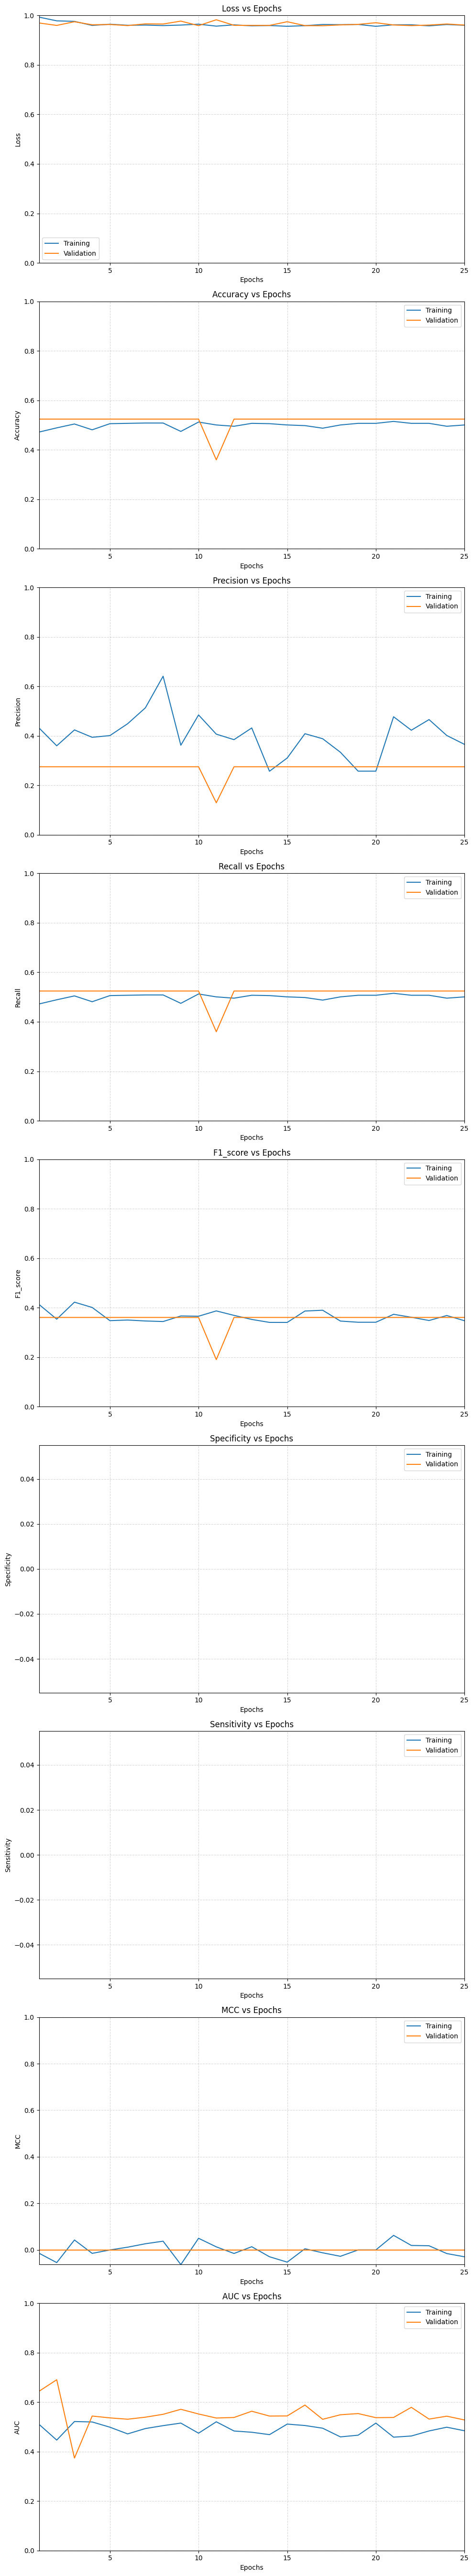

In [15]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    
    # Create subplots. If there's only one metric, axes is made into a list.
    if num_metrics == 1:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    
    rng = range(1, num_epochs + 1)
    
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        
        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")
        
        # Filter out None values before computing y-axis limits.
        valid_train = [m for m in train_metric if m is not None]
        valid_val = [m for m in val_metric if m is not None]
        
        if valid_train or valid_val:
            max_metric = max((max(valid_train) if valid_train else float('-inf')),
                             (max(valid_val) if valid_val else float('-inf')))
            min_metric = min((min(valid_train) if valid_train else float('inf')),
                             (min(valid_val) if valid_val else float('inf')))
            y_max = math.ceil(max_metric)
            if min_metric > 0 or max_metric > 1:
                ax.set_ylim(0, y_max)
            else:
                ax.set_ylim(min_metric, y_max)
        
        ax.grid(True, linestyle='--', alpha=0.5)
        # Only set x-axis limits if there is more than one epoch.
        if num_epochs > 1:
            ax.set_xlim(1, num_epochs)
    
    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [16]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_value is None:
        testing_metrics_line += f"{metric_name}: N/A, "
    elif metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(testing_metrics_line)

Testing Model: 100%|██████████| 21/21 [00:00<00:00, 21.92it/s]

Metrics - loss: 0.9416, accuracy: 0.5181, precision: 0.2684, recall: 0.5181, f1_score: 0.3536, specificity: N/A, sensitivity: N/A, mcc: 0.0000, auc: 0.5729


In [17]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                 precision    recall  f1-score   support

   Bengin cases     0.0000    0.0000    0.0000        17
Malignant cases     0.5181    1.0000    0.6825        86
   Normal cases     0.0000    0.0000    0.0000        63

       accuracy                         0.5181       166
      macro avg     0.1727    0.3333    0.2275       166
   weighted avg     0.2684    0.5181    0.3536       166

There were 80 errors in 166 tests for an accuracy of  51.81


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


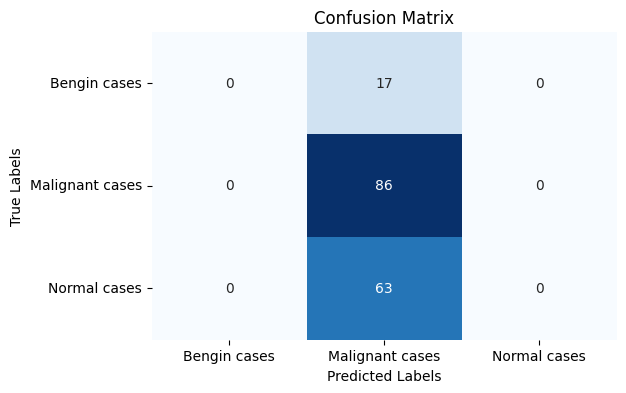

In [18]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [19]:
# --- Step 1: Gather True Labels and Predicted Probabilities ---
true_labels = []
predicted_probs = []

# Ensure model is in evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Processing test batches"):
        images = images.to(next(model.parameters()).device)
        outputs = model(images)  # Assuming model outputs logits or probabilities
        # If outputs are logits, apply softmax
        probabilities = torch.softmax(outputs, dim=1)
        
        predicted_probs.append(probabilities.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Concatenate batches
predicted_probs = np.concatenate(predicted_probs, axis=0)  # shape: (n_samples, n_classes)
true_labels = np.concatenate(true_labels, axis=0)          # shape: (n_samples,)

# If true_labels are not one-hot encoded, convert them:
if true_labels.ndim == 1:
    num_classes = predicted_probs.shape[1]
    true_labels_onehot = label_binarize(true_labels, classes=range(num_classes))
else:
    num_classes = true_labels.shape[1]
    true_labels_onehot = true_labels

# Ensure we have a list of class names of the right length.
try:
    if len(classes) != num_classes:
        classes = [f"Class {i}" for i in range(num_classes)]
except NameError:
    classes = [f"Class {i}" for i in range(num_classes)]

Processing test batches: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


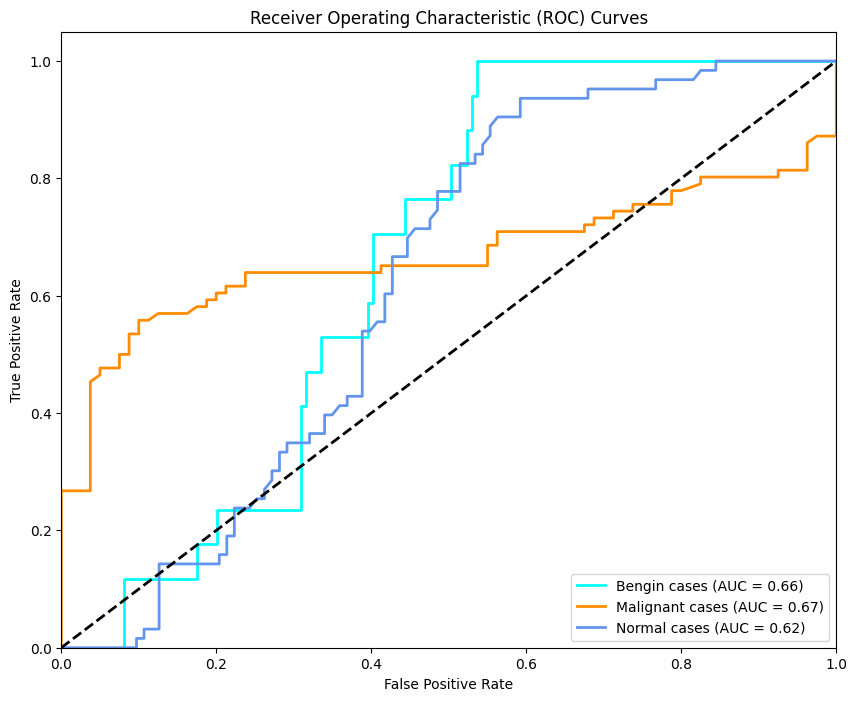

Saved ROC plot with only curves as 'roc_plot_no_labels.png'


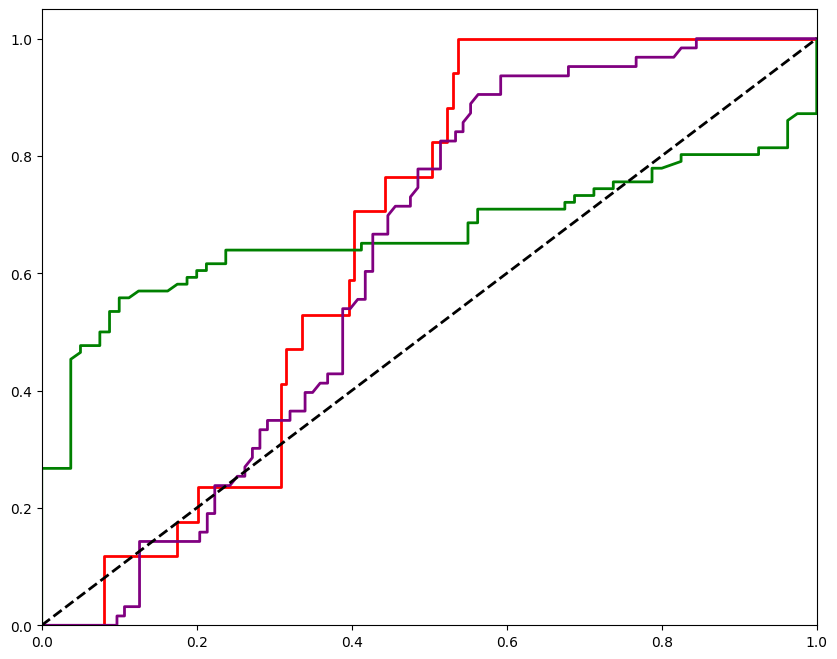

In [20]:
# --- Step 2: Compute ROC Curve and AUC for Each Class ---
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    # This may trigger UndefinedMetricWarning if there are no positive samples for a class.
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Step 3: Create the ROC Plot with Labels ---
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# --- Optional: Create a version without any labels (curves only) ---
fig, ax = plt.subplots(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2)
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.savefig("roc_plot_no_labels.png", bbox_inches='tight')
print("Saved ROC plot with only curves as 'roc_plot_no_labels.png'")
plt.show()

In [21]:
# --- Step 4: Save the ROC Data to an Excel File ---
excel_filename = "roc_data.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for i in range(num_classes):
        df = pd.DataFrame({
            'FPR': fpr[i],
            'TPR': tpr[i]
        })
        df['AUC'] = roc_auc[i]  # Same value for all rows
        # Excel sheet names are limited to 31 characters.
        sheet_name = classes[i][:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"ROC metrics saved to {excel_filename}")

ROC metrics saved to roc_data.xlsx
